<a href="https://colab.research.google.com/github/C191248TahiaHoque/Machine-Learning-project/blob/main/Heart_Failure_Clinical_Records.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#Important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

#Important functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

**Loading the data**

In [10]:
df=pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head(10)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1
7,60.0,1,315,1,60,0,454000.00,1.1,131,1,1,10,1
8,65.0,0,157,0,65,0,263358.03,1.5,138,0,0,10,1
9,80.0,1,123,0,35,1,388000.00,9.4,133,1,1,10,1


**Pre-processing**

Starting off, each of the quantitative variables present in the dataset will be transformed and standardized to approximate a standard normal distribution, i.e.  X∼N(0,1)

This procedure brings about many advantages in the scope of a Bayesian analysis, such as

Prior distributions of the model coefficients can be shared
Inference becomes straightforward, e.g. discarding input variables defaults to the respective sample averages

In [13]:
# Make sure there are no missing values
assert not df.isnull().values.any()

# Index binary variables
is_binary = df.isin([0,1]).all().values

# Split variable types and keep record of var names
X_bin = df.iloc[:, is_binary]
X_quant = df.iloc[:, ~is_binary]

# Store var names as lists
bin_names = df.columns[is_binary].tolist()
quant_names = df.columns[~is_binary].tolist()

# Box-Cox transform of quant variables, then standardize
X_quant = X_quant.apply(lambda x: stats.boxcox(x)[0])
X_quant = StandardScaler().fit_transform(X_quant)

# Look into proportions in binary variables
print('Proportions in binary variables:\n', X_bin.mean())

Proportions in binary variables:
 anaemia                0.431438
diabetes               0.418060
high_blood_pressure    0.351171
sex                    0.648829
smoking                0.321070
DEATH_EVENT            0.321070
dtype: float64


As seen from above, the mean of all binary variables falls in the range  [0.3,0.7]  which given the sample size of  N=299 should present no problem.

**Exploratory Data Analysis(EDA)**

In [3]:
df.shape #(Rows,Columns)

(299, 13)

In [4]:
df.info() #all features, total number of tuples and data type of `train` data set

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


<Axes: >

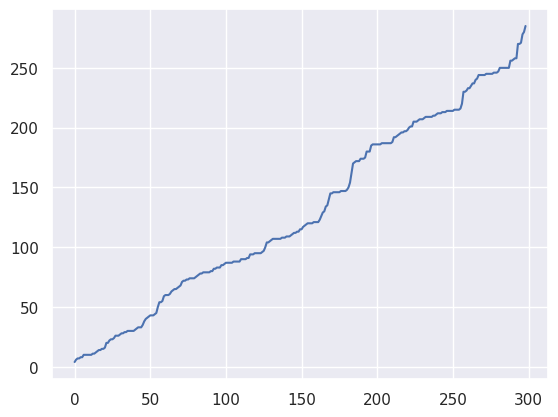

In [7]:
df['time'].plot()

**Data Visualization**

Distplot of all the features to understand how all the features are distributed

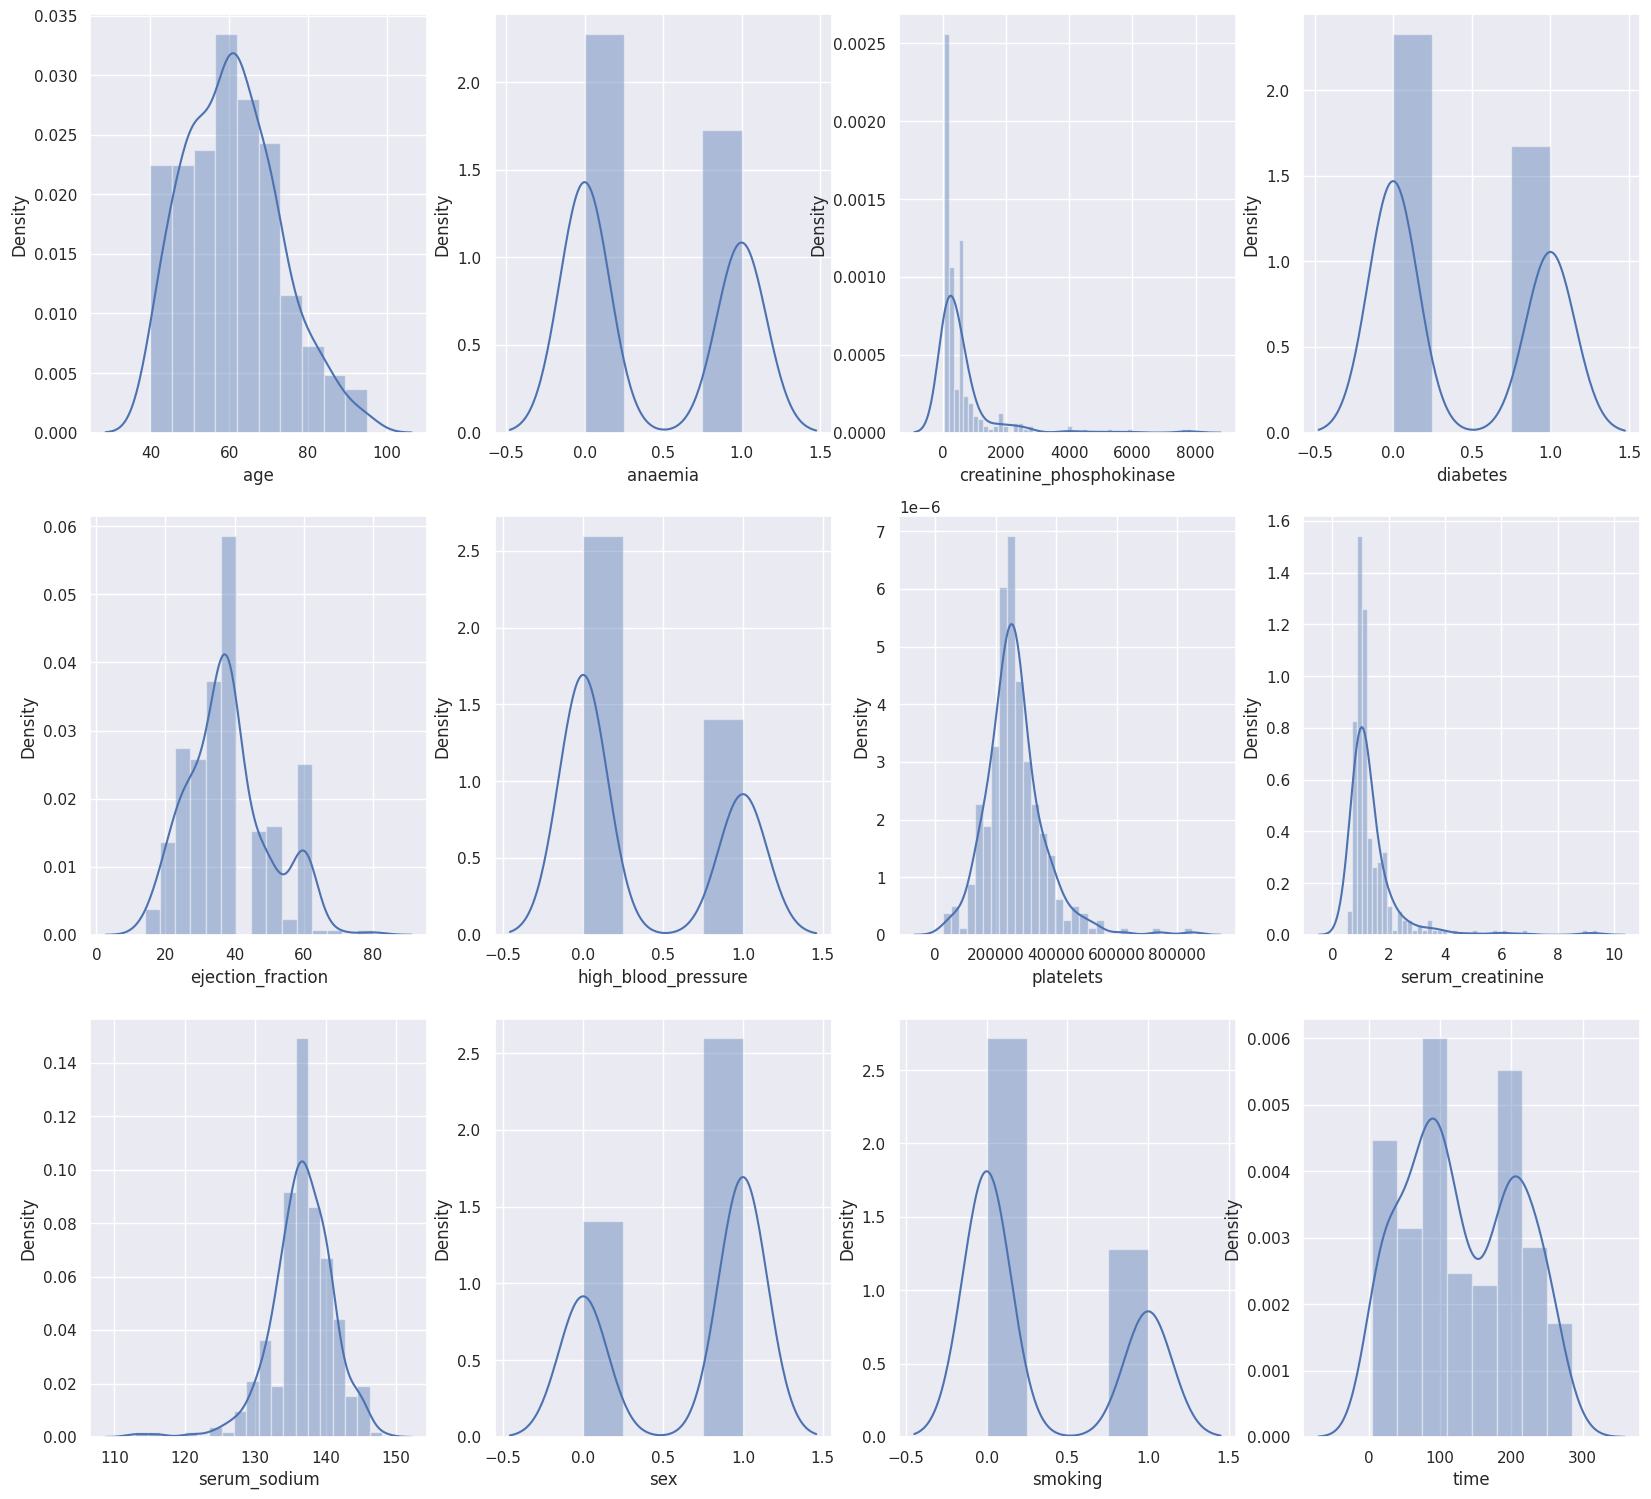

In [16]:
plt.figure(figsize = (20, 25))
feature_num = 1
for i in df:
    if feature_num < 13:
        ax = plt.subplot(4, 4, feature_num)
        sns.distplot(df[i])
        plt.xlabel(i, fontsize = 12)

    feature_num += 1
plt.show()

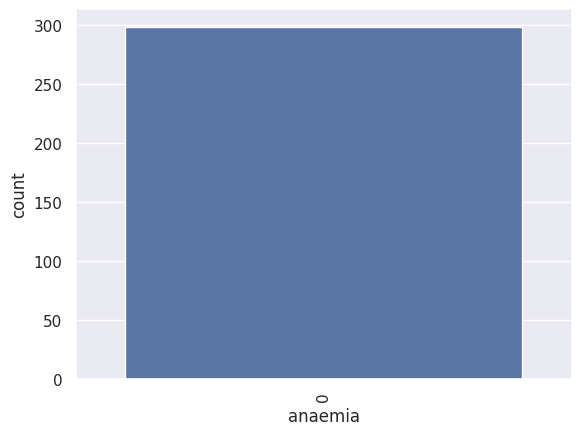

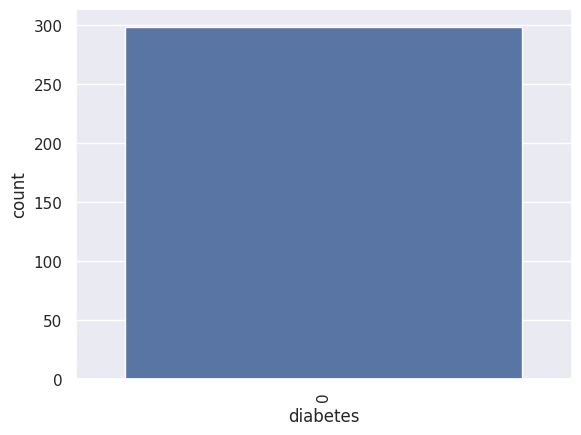

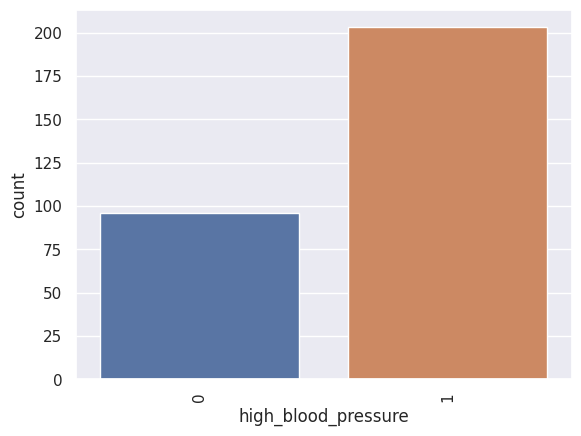

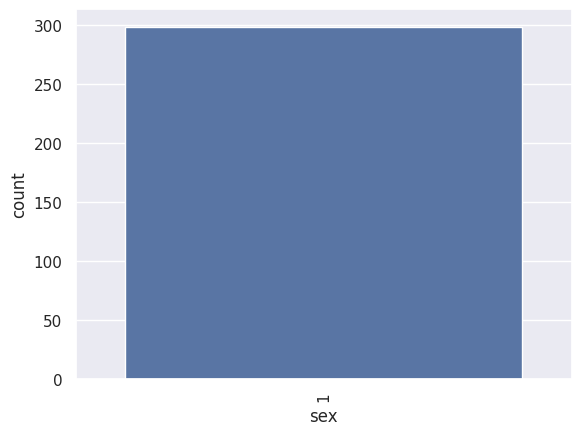

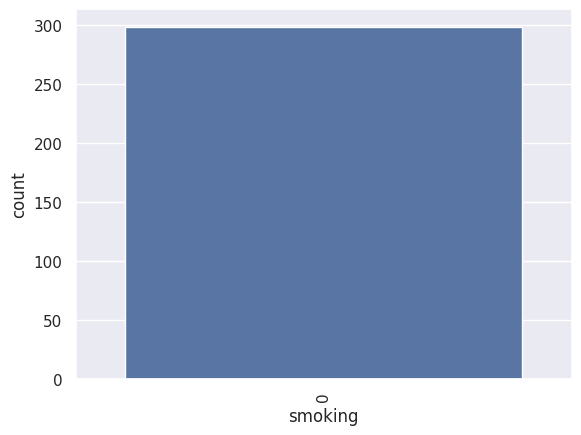

In [23]:
#We will try to find the relationship of some siginificant numeric(discrete) attributes with death
def died(param):
    g = sns.countplot(df[param],x=df.DEATH_EVENT)
    plt.xticks(rotation=90);
    plt.show()
attributes=['anaemia', 'diabetes','high_blood_pressure', 'sex', 'smoking']
for attribute in attributes:
    died(attribute)

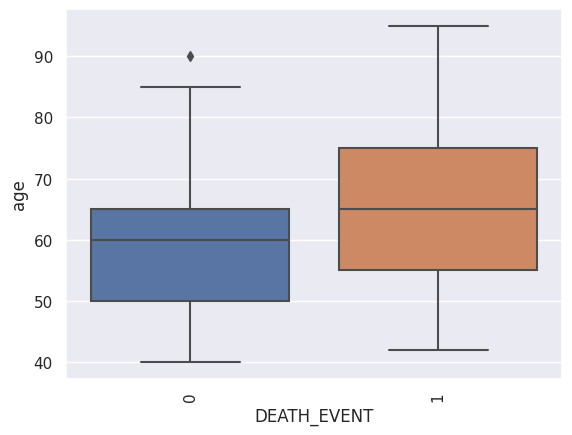

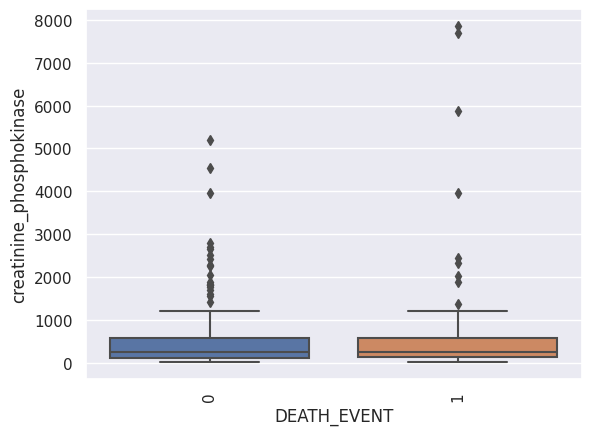

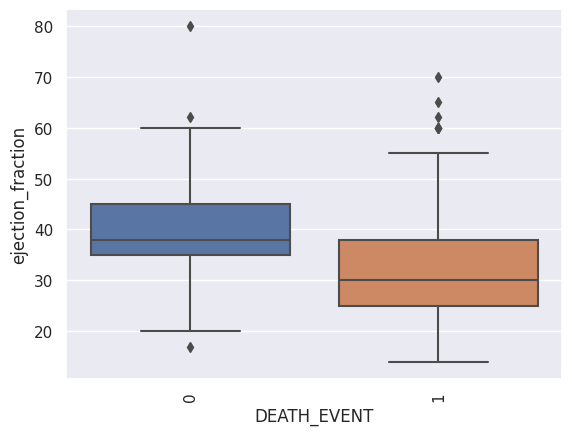

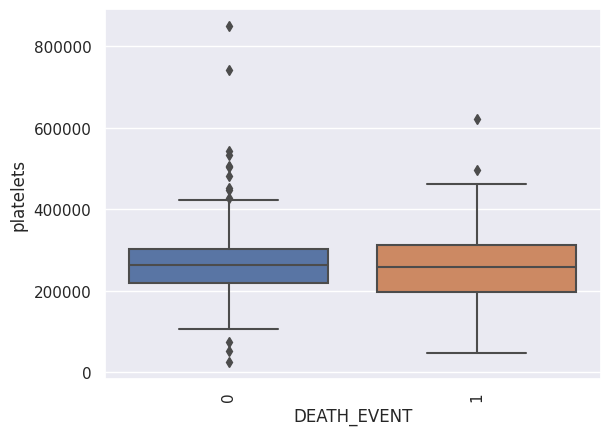

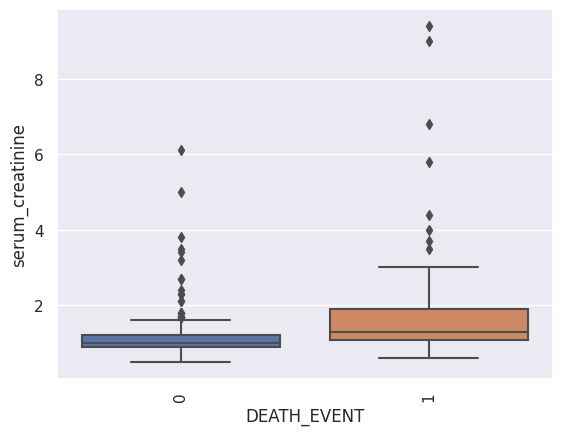

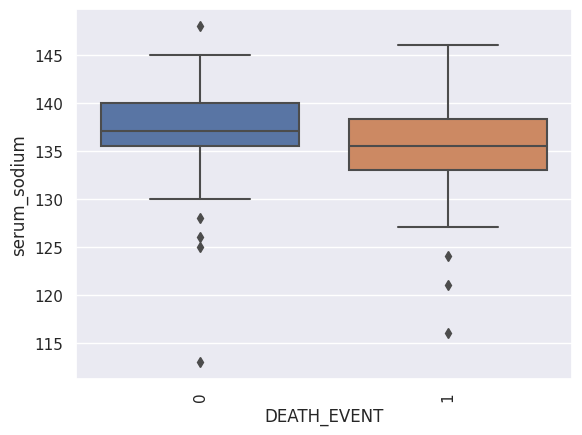

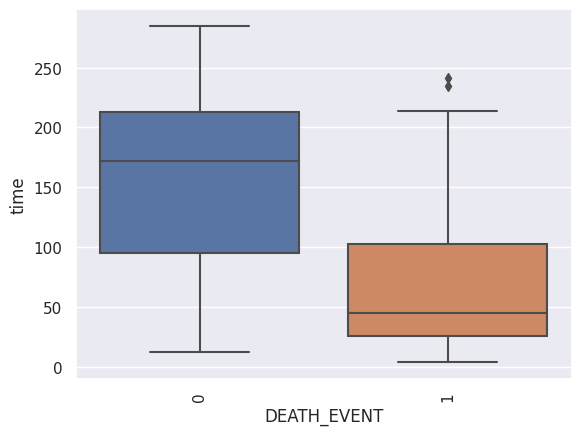

In [25]:
#We will try to find the relationship of some siginificant numeric(continuous) attributes with death
def plt_transported(param):
    sns.boxplot(y=df[param],x=df.DEATH_EVENT)
    plt.xticks(rotation=90);
    plt.show()
attributes=['age','creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
for attribute in attributes:

    plt_transported(attribute)

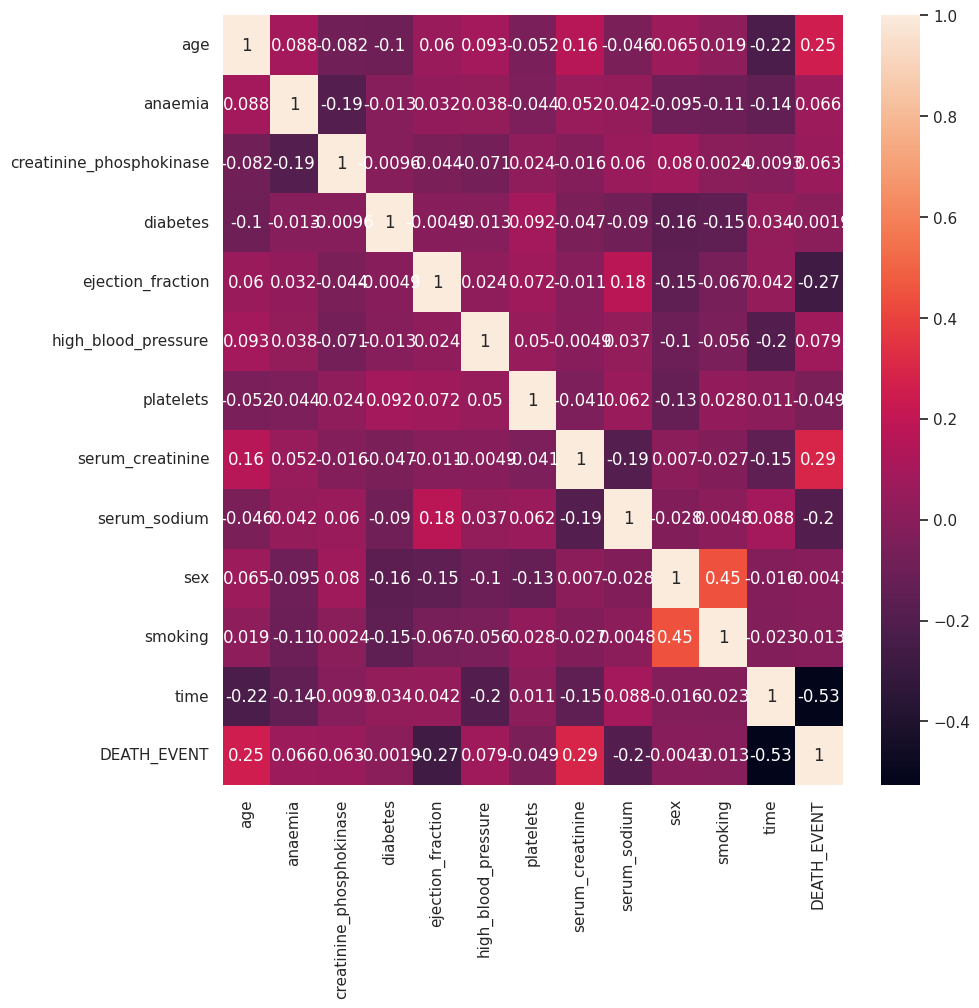

In [26]:
#Correlation Heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True);

**Conclusions from the heatmap :**

1.Death event looks to be highly correlated with serum_creatinine and age

2.Survival event looks to be highly correlated with time ejection_fraction, serum_sodium

3.Sex and smoking have the least correlation with DEATH_EVENT, we can consider dropping these features

In [29]:
df.corr()['DEATH_EVENT'].sort_values(ascending=False)

DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
high_blood_pressure         0.079351
anaemia                     0.066270
creatinine_phosphokinase    0.062728
diabetes                   -0.001943
sex                        -0.004316
smoking                    -0.012623
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64

**Binary variables**
Any interdependencies among binary variables can be assessed from a Cramér's V correlation matrix. Note that I discard the  χ2
  Yates' continuity correction below, by passing correction=False to more rigorously fulfil unit value with self-correlation. You can see for yourself how little difference it makes if enabled.

<Axes: >

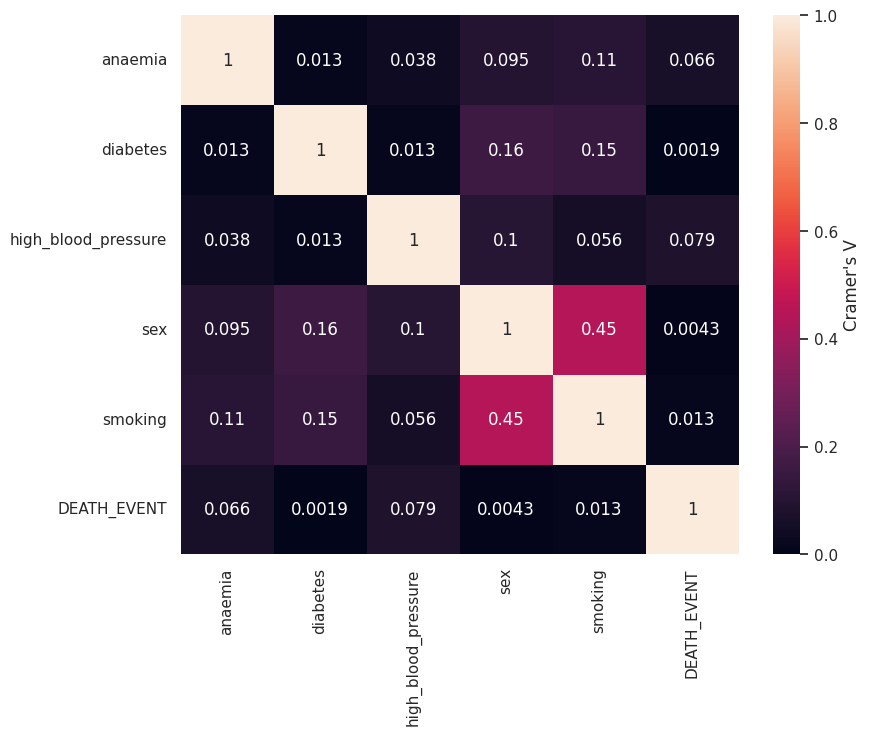

In [27]:
# NOTE: This function should only take binary variables
def cramers_v(x, y):
    # Confusion matrix
    conf_matrix = pd.crosstab(x, y)
    # Compute chi-squared w/o Yates' continuity correction
    chi2 = stats.chi2_contingency(conf_matrix, correction=False)[0]
    n = sum(conf_matrix.sum())
    # With binary variables we have V = np.sqrt(chi2 / n)
    return np.sqrt(chi2 / n)

# Create and populate correlation matrix
corr_bin = np.eye(X_bin.shape[1])
for r in range(X_bin.shape[1]):
    for c in range(X_bin.shape[1]):
        corr_bin[r,c] = cramers_v(X_bin.iloc[:,r], X_bin.iloc[:,c])

# Plot correlation matrix
sns.set(rc={'figure.figsize':(9, 7)})
sns.heatmap(corr_bin, vmin=0, vmax=1, annot=True,
            cbar_kws={'label': "Cramer's V"},
            xticklabels=bin_names, yticklabels=bin_names)

What clearly jumps to sight from the correlation matrix above is the intriguing association between smoking and sex. On closer look, we have 96% of non-smokers among women (101/105) but only 53% among men (102/194). Here too, you can see this for yourself using a confusion matrix, e.g. pd.crosstab(X_bin['smoking'], X_bin['sex']). This dependence between the two factors would require special handling upon modelling, by means of introducing interaction effects or other strategies

**Quantitative variables**

In a similar vein we proceed to examine any existing interdepencencies among the normalized quantitative variables. Here I would argue we do not need to compute and examine similarity metrics, and can directly visualize the bivariate distributions over all such features. The following figure will additionally distinguish smokers from non-smokers using different colors.

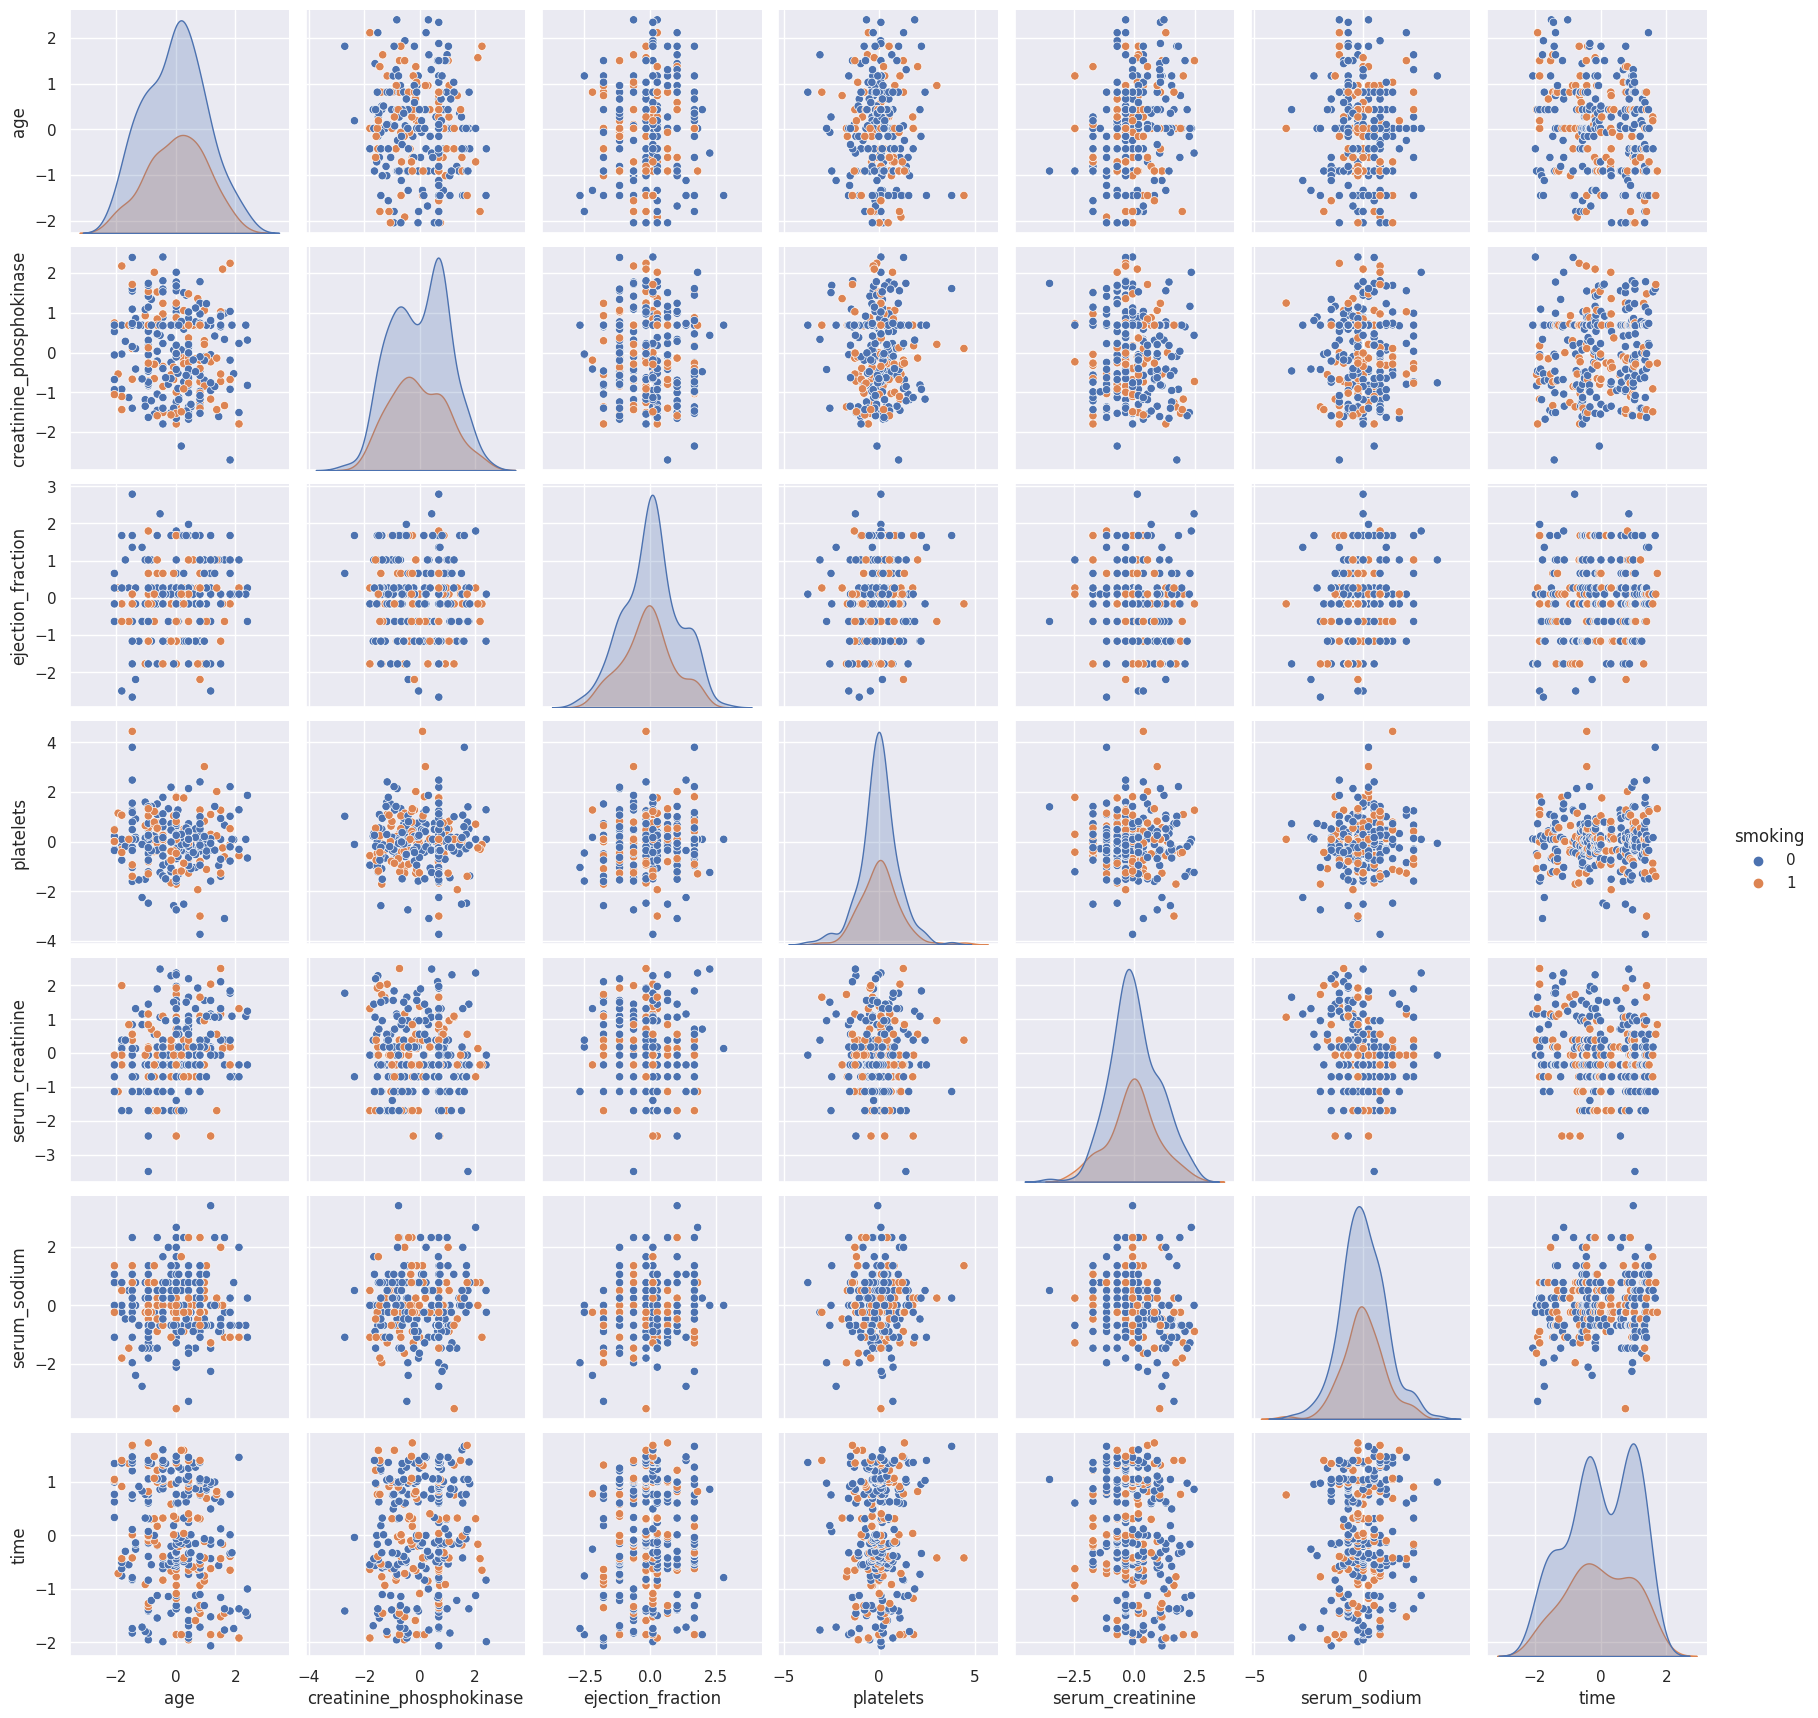

In [28]:
# Create dataframe to enable pairplot
data_pairplot = pd.DataFrame(X_quant, columns=quant_names)
data_pairplot['smoking'] = X_bin.smoking

# Pairplot (quantitative variables)
sns.pairplot(data=data_pairplot, hue='smoking')

**Data Cleaning**

Data cleaning is the first step to prepare datasets to ensure that there is no missing values occurs during the application because most machine learning algorithms cannot work with missing features.

Two common ways to deal with missing values are as follows:

i. Get rid of data with missing values by using dropna().
ii. Fill in some values to missing values by using fillna().

In [30]:
#Missing values from the train data
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

No missing values!!That's great!!

**Principal Component Analysis (PCA)**

Performing a principal component analysis (PCA) of the normalized quantitative variables and visualize the scores over the first two principal components (PCs). This should both provide us an overview over the sample composition, e.g. presence of outliers and help assessing whether the projections carrying the most variance relate to heart failure incidence

Text(0, 0.5, 'PC2 (17.39%)')

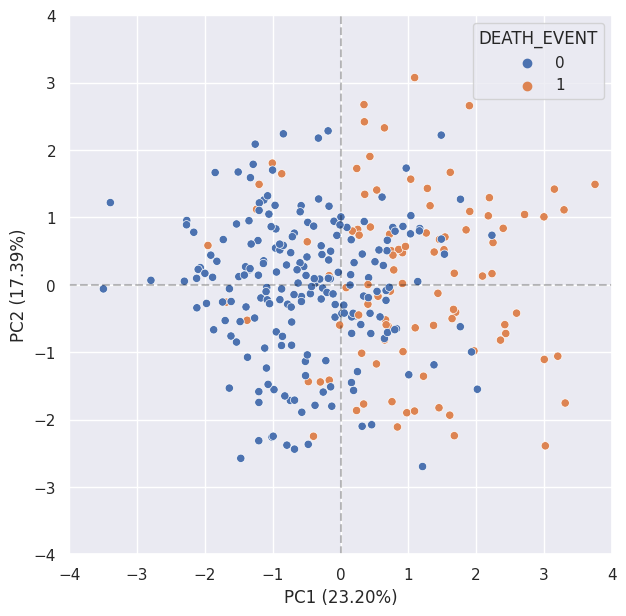

In [56]:
# Fit PCA
pca_model = PCA(n_components=2).fit(X_quant)
explained_var = pca_model.explained_variance_ratio_*100
scores = pd.DataFrame(pca_model.transform(X_quant), columns=['PC1','PC2'])
scores['DEATH_EVENT'] = X_bin.DEATH_EVENT

# PC1-2 scatterplot
sns.set(rc={'figure.figsize':(7, 7)})
sns.scatterplot(x='PC1', y='PC2', data=scores,
               hue='DEATH_EVENT')

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.axhline(0, linestyle='--', color='black', alpha=.25)
plt.axvline(0, linestyle='--', color='black', alpha=.25)
plt.xlabel('PC1 ({exp_var:.2f}%)'.format(exp_var=explained_var[0]))
plt.ylabel('PC2 ({exp_var:.2f}%)'.format(exp_var=explained_var[1]))

**Scaling the features using Standard Scaler**

ML algorithms are very sensitive differences in scales of various features
In this particular case the platelets feature has a huge magnitude when compared to other features
This can considerably offset the accuracy of our results
Hence scaling is necessary

In [39]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
y = df['DEATH_EVENT']
df_scaled = ss.fit_transform(df.drop(('DEATH_EVENT'),axis=1))
df_scaled = pd.DataFrame(data=df_scaled,columns=df.columns[:-1])
df_scaled = pd.concat([df_scaled,y],axis=1)

In [40]:
df_scaled

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,-1.629502,1
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,-1.603691,1
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,-1.590785,1
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,-1.590785,1
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,-1.577879,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161,1.803451,0
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682,1.816357,0
296,-1.333392,-0.871105,1.525979,1.179830,1.854958,-0.735688,4.902082e+00,-0.575031,0.312044,-1.359272,-0.687682,1.906697,0
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161,1.932509,0


**Plot Boxplots to find outliers**

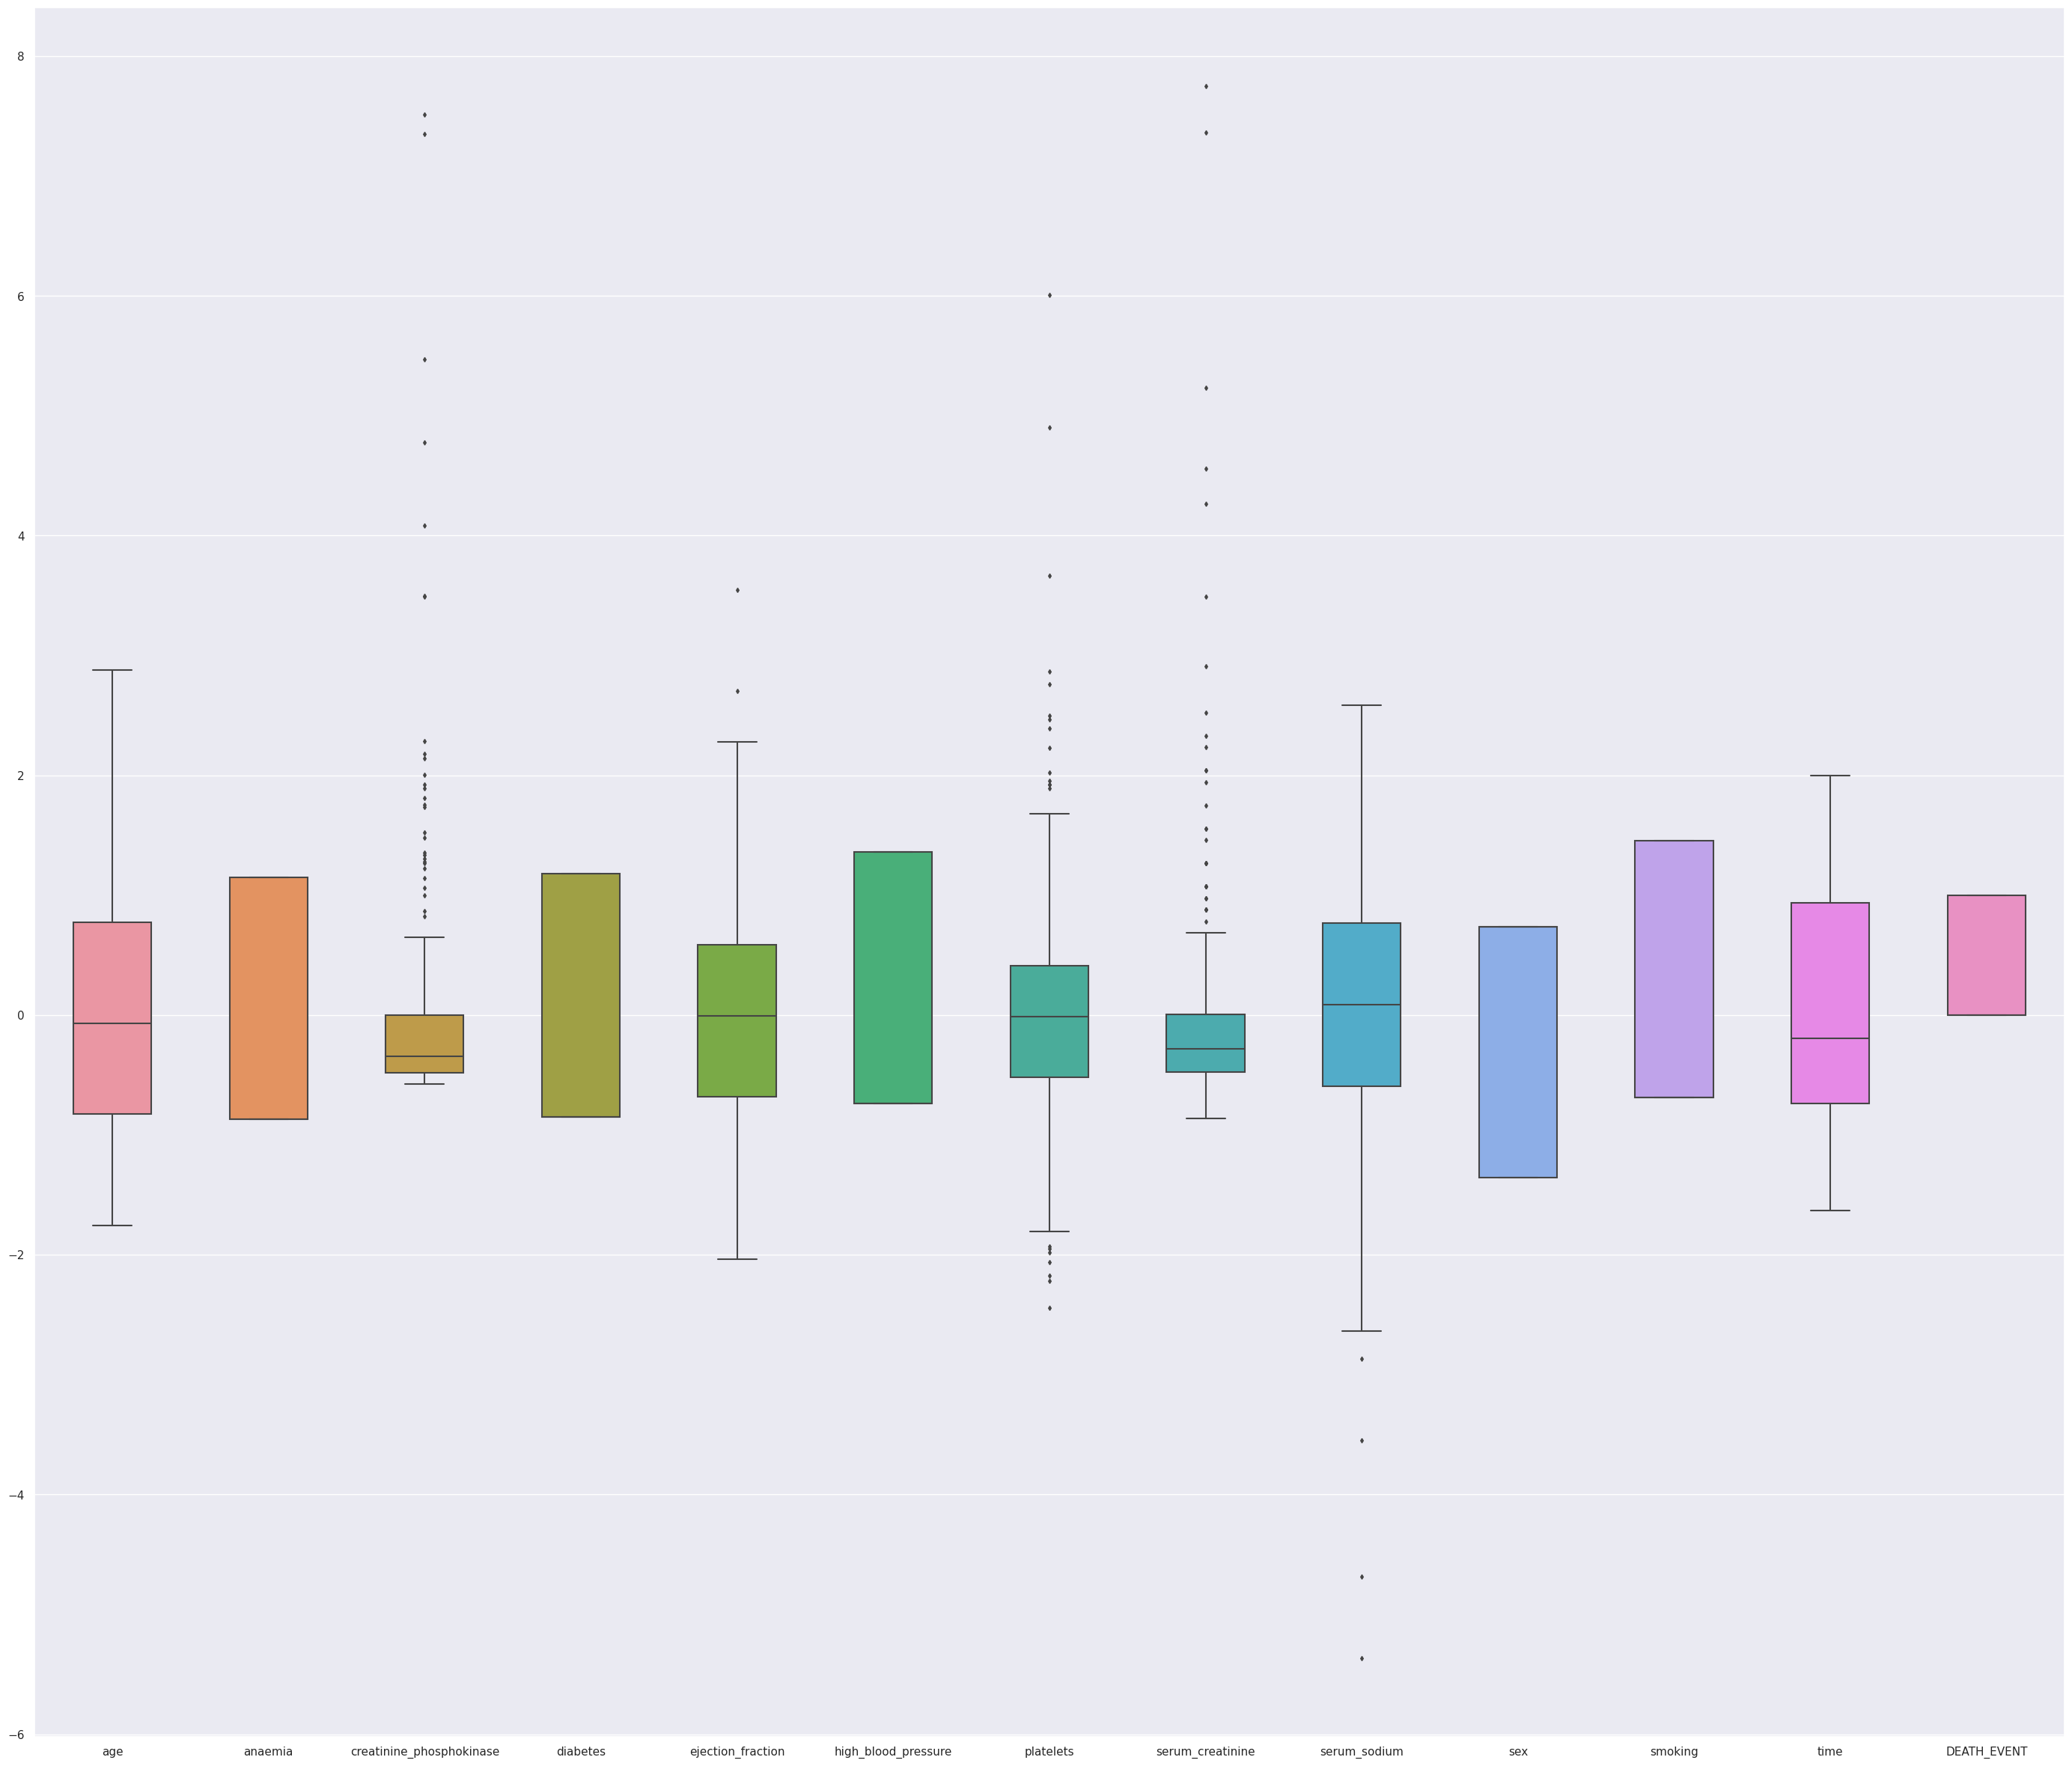

In [42]:
fig, ax = plt.subplots(figsize = (35, 30))
sns.boxplot(data = df_scaled, width = 0.5, ax = ax, fliersize = 3)
plt.show()

Treating Outliers with Principal Component Analysis

Principal component analysis can be used to find the features that explain the most of the variance(95-100%) in the dataset.

Most of the times we do not need all the features in the input dataset to explain the variance.

Hence this can be used to :

1.Drop unwanted features

2.Drop unwanted rows that act as outliers

The inbuilt sklearn pca does not give us the top features(best features to use), the location of outliers in the dataset There is this cool library called pca that does both and hence we will be using the same.

In [43]:
pip install pca

In [44]:
from pca import pca
model = pca(n_feat=12,n_components=12) #considering all the 12 features as I do not want to eliminate columns
df_scaled_x = model.fit_transform(df_scaled.drop(('DEATH_EVENT'),axis=1))

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [12] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[12]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [45]:
df_scaled_x['topfeat']

,PC,feature,loading,type
0,PC1,sex,0.622376,best
1,PC2,time,-0.510580,best
2,PC3,serum_sodium,-0.625528,best
3,PC4,platelets,0.508584,best
4,PC5,creatinine_phosphokinase,0.510700,best
5,PC6,platelets,0.522382,best
6,PC7,anaemia,0.615947,best
7,PC8,diabetes,-0.675612,best
8,PC9,age,-0.655096,best
9,PC10,serum_sodium,0.541121,best


In [46]:
outliers = df_scaled_x['outliers']
outliers_ = outliers[outliers['y_bool_spe']==True]

In [47]:
outliers_.reset_index(inplace=True)

In [48]:
outliers_index = outliers_['index']

In [49]:
outliers_index #gives the index of the outliers in the dataset

0      5
1      9
2     48
3    296
Name: index, dtype: int64

Let us drop the outliers

In [50]:
df_new = df_scaled.drop(outliers_index,axis=0)

In [51]:
df_new

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,-1.629502,1
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,-1.603691,1
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,-1.590785,1
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,-1.590785,1
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,-1.577879,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.182411,1.147968,-0.494330,1.179830,-0.260991,-0.735688,-8.639651e-01,-0.478205,-0.141976,0.735688,1.454161,1.803451,0
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161,1.803451,0
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682,1.816357,0
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161,1.932509,0


Let us see if there are some more outliers in the dataset after PCA

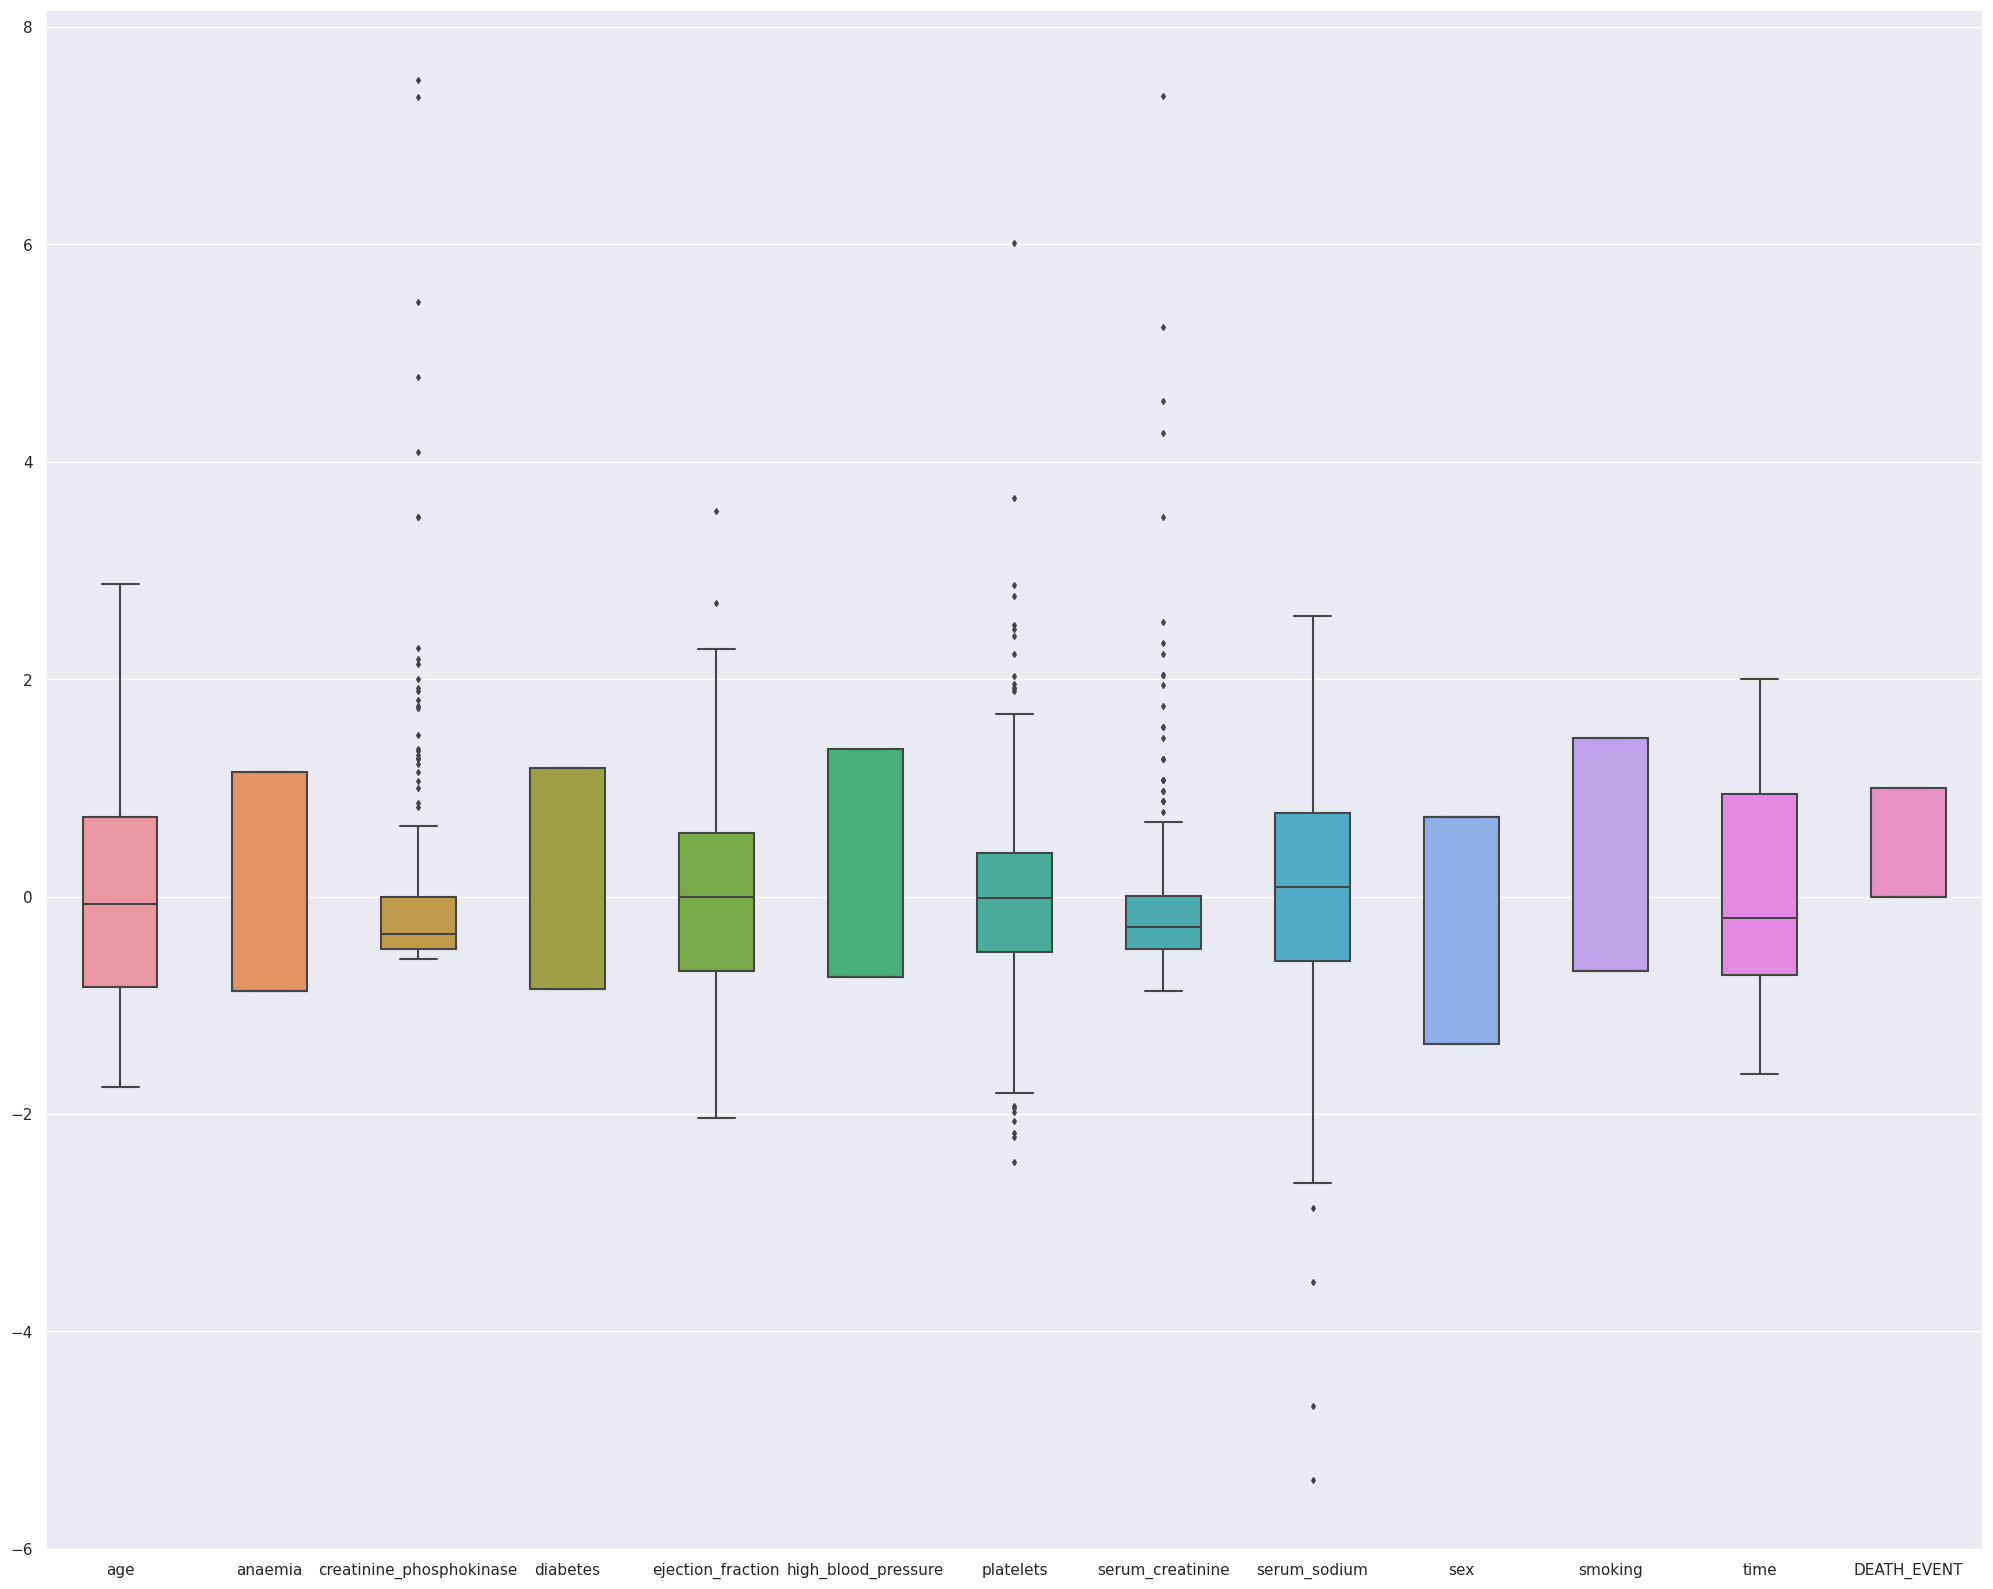

In [55]:
fig, ax = plt.subplots(figsize = (25, 20))
sns.boxplot(data = df_new, width = 0.5, ax = ax, fliersize = 3)
plt.show()

Looks like there are some more outliers and we have to clean them up



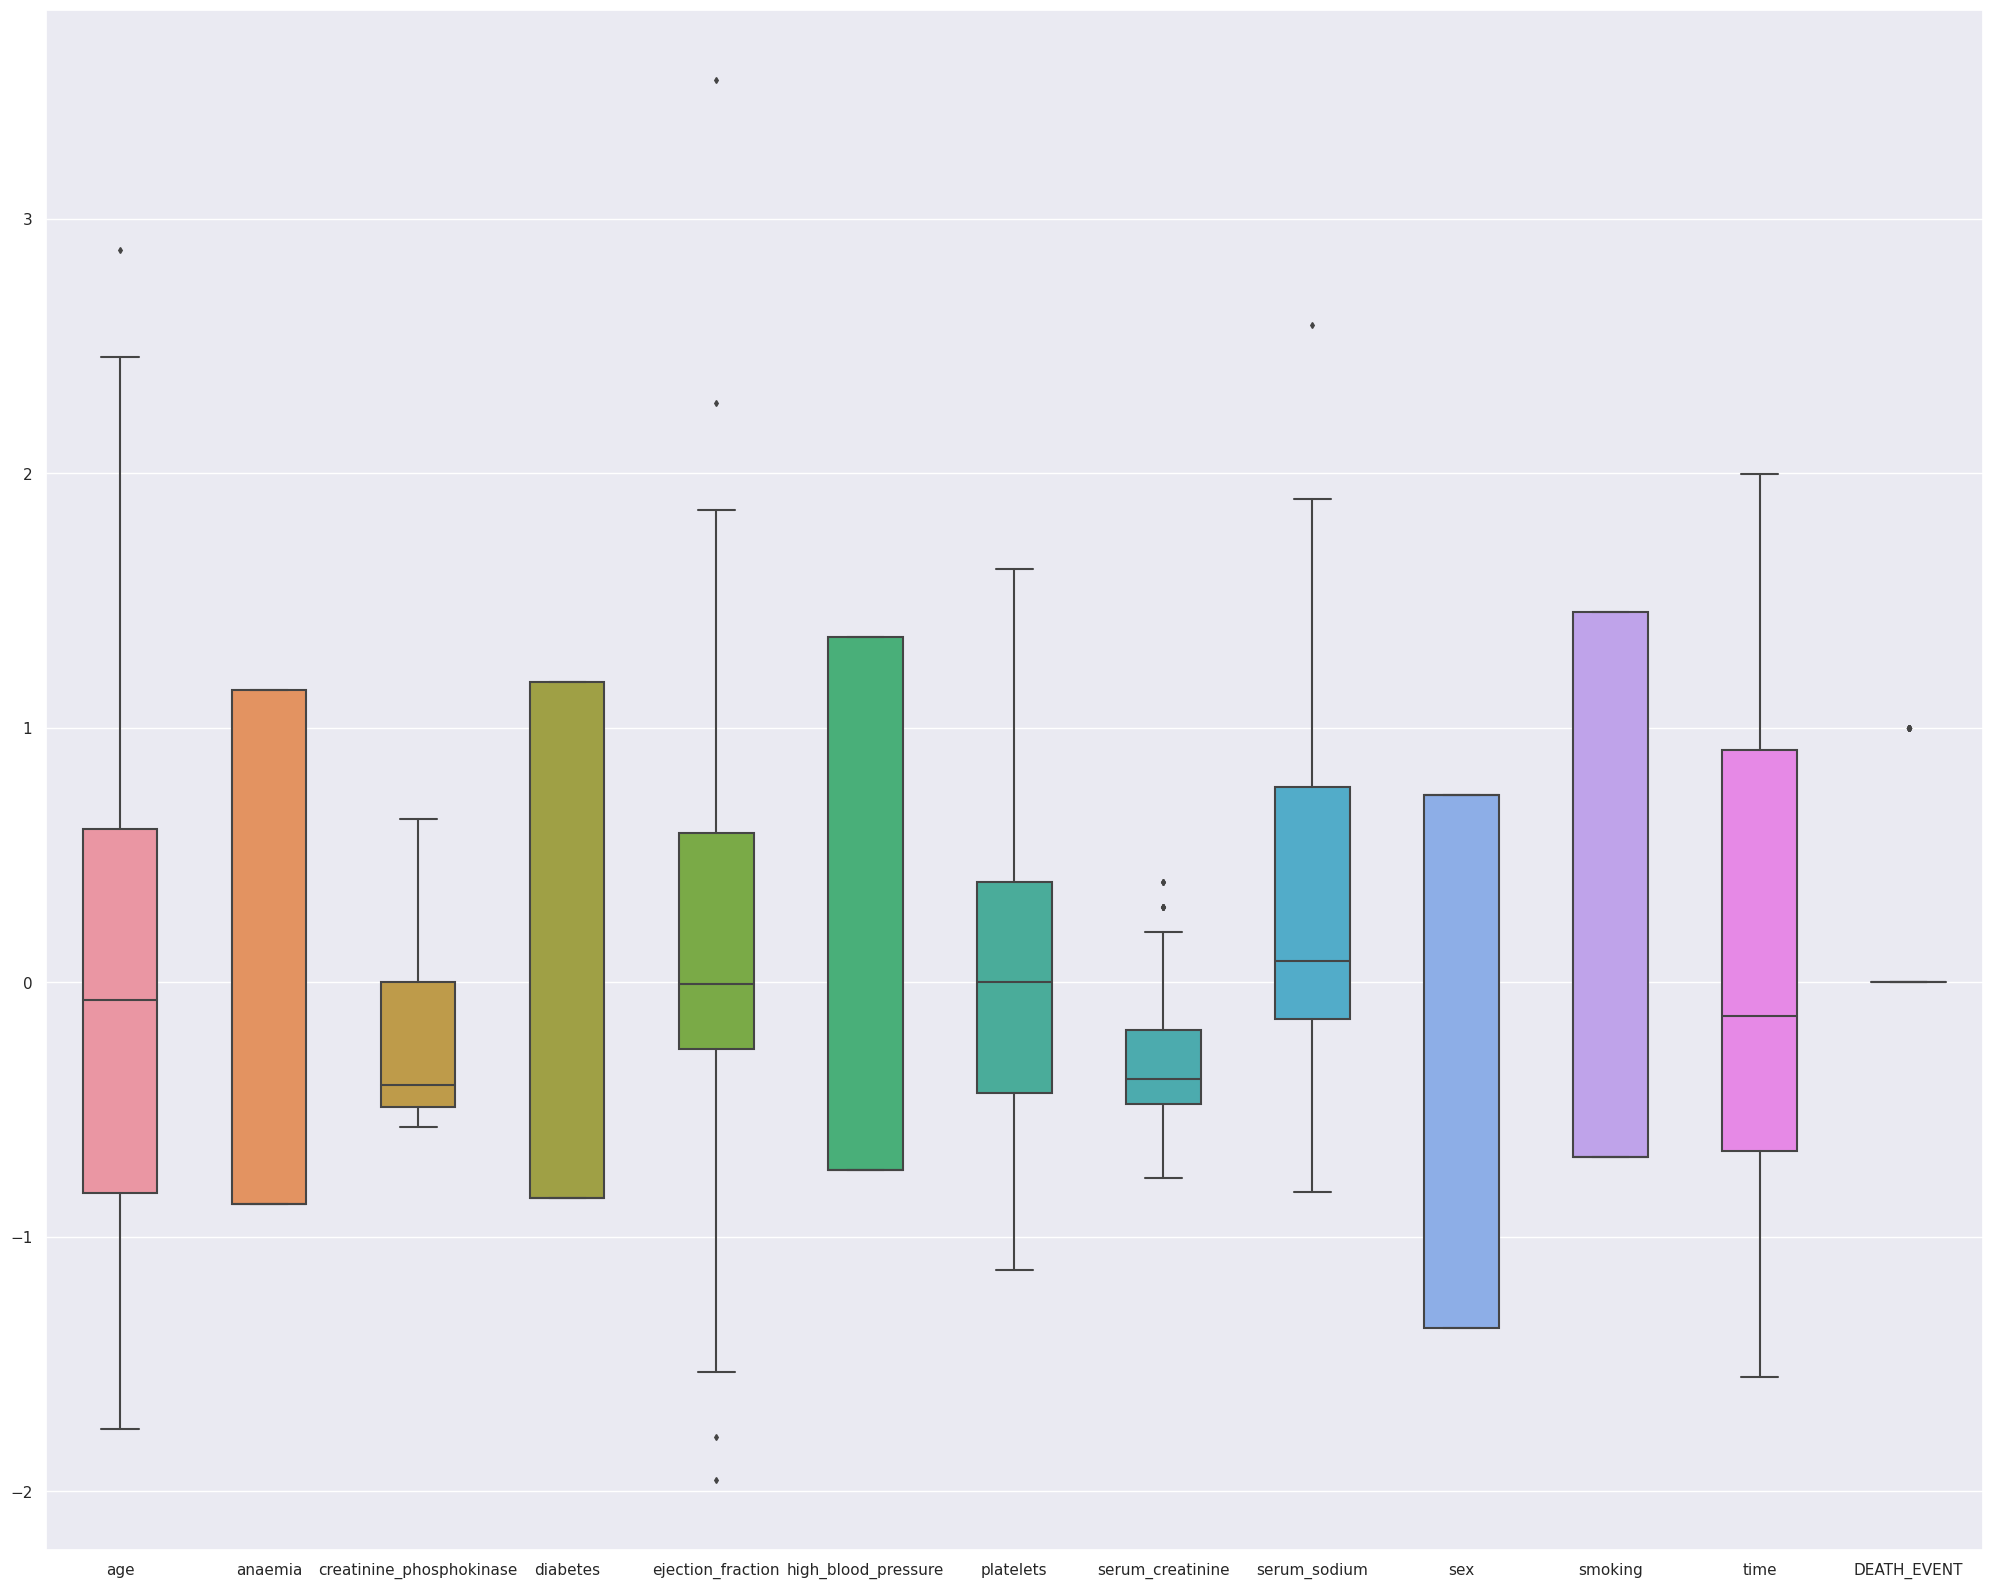

In [54]:
df_exp = df_scaled[df_scaled['platelets'] < df_scaled['platelets'].quantile(0.95)]
df_exp = df_exp[df_exp['platelets'] > df_exp['platelets'].quantile(.1)]
df_exp = df_exp[df_exp['serum_sodium'] > df_exp['serum_sodium'].quantile(.1)]
df_exp = df_exp[df_exp['serum_creatinine'] < df_exp['serum_creatinine'].quantile(0.9)]
df_exp = df_exp[df_exp['creatinine_phosphokinase'] < df_exp['creatinine_phosphokinase'].quantile(0.91)]
fig, ax = plt.subplots(figsize = (25, 20))
sns.boxplot(data = df_exp, width = 0.5, ax = ax, fliersize = 3)
plt.show()

We have cleaned up most of the outliers, do not want to drop more samples as it may reduce the amount of data input
to ML algorithms for classification

**Modeling**

In [31]:
#Seperating Response Variable from the dataset
X=df.drop('DEATH_EVENT',axis=1)
y=df['DEATH_EVENT']

In [32]:
#train_test_split()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=2)

In [33]:
#Models
models=[]
models.append(('LR',LogisticRegression(solver='liblinear',multi_class='ovr')))
models.append(('DT',DecisionTreeClassifier()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(gamma='auto')))
models.append(('RFC',RandomForestClassifier()))

In [34]:
#Evaluation of models
results=[]
names=[]
for name,model in models:
    kfold=StratifiedKFold(n_splits=20)#random_state=1
    cv_results=cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' %(name,cv_results.mean(),cv_results.std()))

LR: 0.815909 (0.124300)
DT: 0.735227 (0.164334)
LDA: 0.793939 (0.118618)
KNN: 0.638258 (0.087822)
NB: 0.753409 (0.114152)
SVM: 0.665152 (0.037697)
RFC: 0.789015 (0.133606)


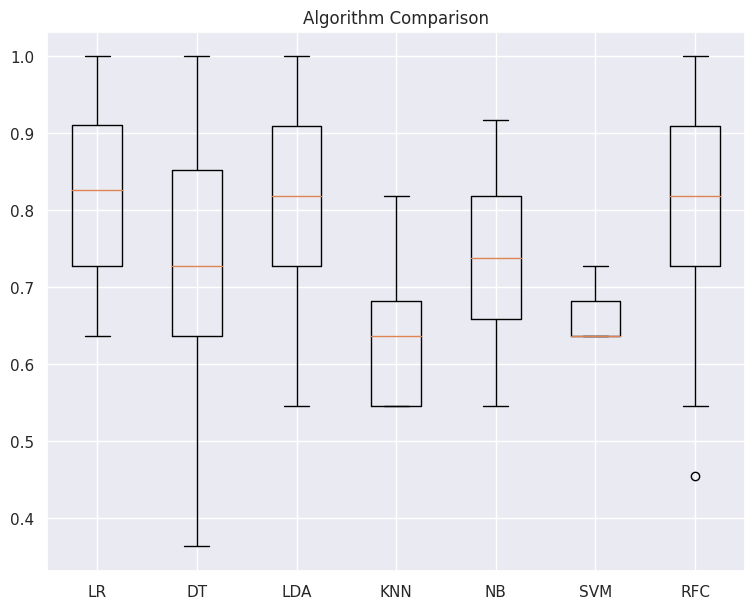

In [35]:
#Compare our models
plt.boxplot(results,labels=names)
plt.title("Algorithm Comparison")
plt.show()

We can see from the above plot that LogisticRegression() and RandomForestClassifier() are our best performing algorithms. We will proceed with both of them.

In [37]:
#Logistic Regression Classifier
lrc = LogisticRegression(solver='liblinear',multi_class='ovr')
lrc.fit(X_train,y_train)
pred_y=lrc.predict(X_val)

#Accuracy
print('Accuracy of the LRC:',accuracy_score(y_val.values,pred_y))

Accuracy of the LRC: 0.8933333333333333
Accuracy of the LRC: 0.8933333333333333


In [38]:
#Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
pred_y=rf.predict(X_val)

#Accuracy
print('Accuracy of the RFC:',accuracy_score(y_val.values,pred_y))

Accuracy of the RFC: 0.9066666666666666
